# Kingfisher classifier using deep learning

In [1]:
#hide
!pip install -Uqq fastbook --use-feature=2020-resolver
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

### Download images from duckduckgo 

In [4]:
urls = search_images_ddg('Cerulean kingfisher', max_images=100)
len(urls),urls[0]

(100,
 'https://i.pinimg.com/originals/bf/fb/6b/bffb6b8df0c76e6dc1b4d4114a34ef8f.jpg')

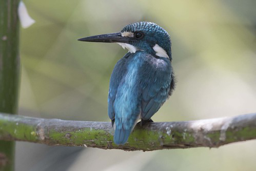

In [5]:
download_url(urls[1], 'images/Cerulean kingfisher.jpg')
im = Image.open('images/Cerulean kingfisher.jpg')
im.thumbnail((256,256))
im

In [6]:
### Train NN with 8 common and cool species

In [7]:
kingfishers = 'common kingfisher', 'white-throated kingfisher', 'grey-headed kingfisher', 'belted kingfisher', 'green kingfisher', 'cerulean kingfisher', 'pied kingfisher', 'black backed kingfisher'
path = Path('kingfishers')

In [8]:
if not path.exists():
    path.mkdir()
    
for o in kingfishers:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(o, max_images =100)
    download_images(dest, urls=results)

In [9]:
path.ls()

(#8) [Path('kingfishers/common kingfisher'),Path('kingfishers/white-throated kingfisher'),Path('kingfishers/green kingfisher'),Path('kingfishers/cerulean kingfisher'),Path('kingfishers/belted kingfisher'),Path('kingfishers/pied kingfisher'),Path('kingfishers/black backed kingfisher'),Path('kingfishers/grey-headed kingfisher')]

In [10]:
fns = get_image_files(path)
fns

(#845) [Path('kingfishers/common kingfisher/00000047.jpg'),Path('kingfishers/common kingfisher/00000055.jpg'),Path('kingfishers/common kingfisher/00000050.JPG'),Path('kingfishers/common kingfisher/00000010.JPG'),Path('kingfishers/common kingfisher/00000036.jpg'),Path('kingfishers/common kingfisher/00000030.jpg'),Path('kingfishers/common kingfisher/00000097.jpg'),Path('kingfishers/common kingfisher/00000029.jpg'),Path('kingfishers/common kingfisher/00000091.jpg'),Path('kingfishers/common kingfisher/00000093.jpg')...]

In [ ]:
#### Check images

In [11]:
failed = verify_images(fns)
failed

(#5) [Path('kingfishers/common kingfisher/00000002.jpg'),Path('kingfishers/green kingfisher/00000022.jpg'),Path('kingfishers/green kingfisher/00000025.jpg'),Path('kingfishers/green kingfisher/00000054.jpg'),Path('kingfishers/black backed kingfisher/00000028.jpg')]

In [12]:
failed.map(Path.unlink);

## DataBlock defines data structure, cross-validation and item transforms in fastai

In [13]:
kingfishers = DataBlock(
                   blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=10),
                   get_y=parent_label,
                   item_tfms=Resize(128))

In [16]:
dls = kingfishers.dataloaders(path)

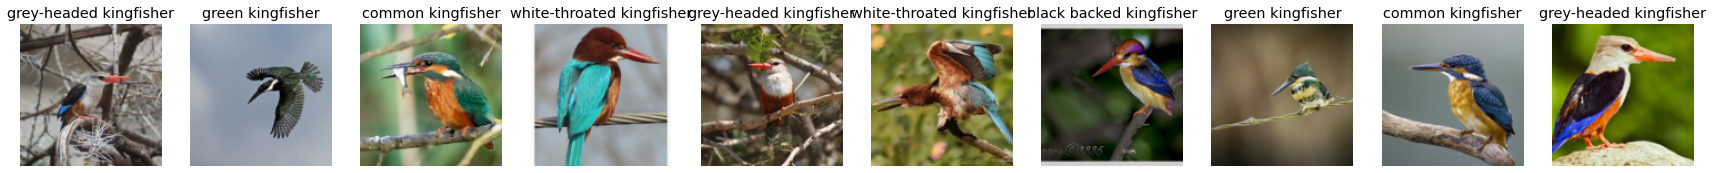

In [17]:
dls.valid.show_batch(max_n=10, nrows=1)

## Use various data augmentations with aug_transforms()

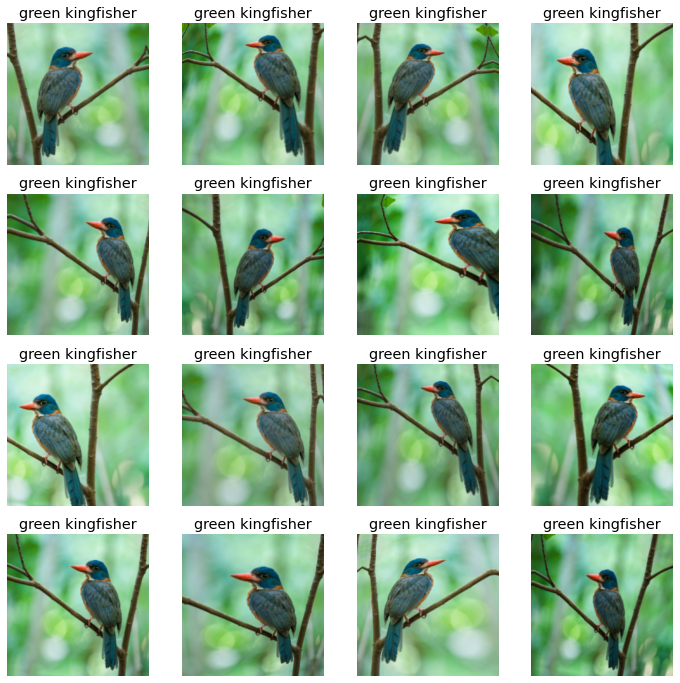

In [20]:
kingfishers=kingfishers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = kingfishers.dataloaders(path)

## Train model (transfer learning based on resnet)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

## Classification looks good

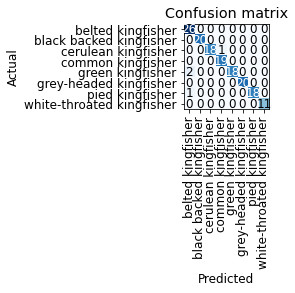

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Turning model into app

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Tryouts, this will go into seperate notebook

In [28]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.predict('images/Cerulean kingfisher.jpg')

('cerulean kingfisher',
 TensorBase(2),
 TensorBase([2.0421e-07, 4.6631e-08, 9.9999e-01, 9.5502e-06, 4.2555e-07, 6.6202e-10, 1.1258e-06, 1.4738e-09]))

In [30]:
learn_inf.dls.vocab

['belted kingfisher', 'black backed kingfisher', 'cerulean kingfisher', 'common kingfisher', 'green kingfisher', 'grey-headed kingfisher', 'pied kingfisher', 'white-throated kingfisher']

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: cerulean kingfisher; Probability: 0.9428')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [42]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])